In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
housing = fetch_california_housing()
print(housing.keys())
print(housing.feature_names)

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [3]:
x_data = housing.data
y_data = housing.target

print(x_data.shape)  ## 20640 개의 data 를 가지고 있는 feature 가 8개
print(y_data.shape)  ## 20640 개의 정답 data

y_data

(20640, 8)
(20640,)


array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(16512, 8)
(16512,)
(4128, 8)
(4128,)


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train) ## fit : 어떠한 분포로 맞춤 | transform : 형태를 바꿔주는 기능(?)
x_test_scaled = scaler.transform(x_test)

x_train_tensor = torch.FloatTensor(x_train_scaled)
y_train_tensor = torch.FloatTensor(y_train)

x_test_tensor = torch.FloatTensor(x_test_scaled)
y_test_tensor = torch.FloatTensor(y_test)

In [6]:
# 데이터 배치화 (100개 단위로 쪼갠 걸 한번 다 훑으면 1 epoch)

## dataloader 에 넣기 위해 x_train_tensor 와 y_train_tensor 를 train_data 로 변환해줌.
train_data = data_utils.TensorDataset(x_train_tensor, y_train_tensor) 

## dataloader 는 data를 batch 단위로 쪼개줌. (drop_last 는 자르고 남는 걸 버릴것이냐)
dataloader = data_utils.DataLoader(train_data, batch_size=100, shuffle=True, drop_last=True)

# 데이터 확인
for batch_idx, (x_batch, y_batch) in enumerate(dataloader):
    print(batch_idx)
    print(x_batch.shape)
    print(y_batch.shape)
    break

0
torch.Size([100, 8])
torch.Size([100])


In [7]:
# parameter 정의
input_size = 8  ## 8개 feature
output_size = 1
learning_rate = 0.01
n_epochs = 100

In [8]:
# model 생성
model = nn.Linear(input_size, output_size)

# 손실함수 생성
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [9]:
# Running the model
train_loss = []
test_loss = []

for epoch in range(n_epochs+1):
    for idx, (x_batch, y_batch) in enumerate(dataloader):
        # Batch학습
        model.train() ## train모드로 바꿔줌.
        optimizer.zero_grad() ## gradiant 초기화
        y_pred = model(x_batch)
        y_pred = y_pred.reshape(-1) # y_batch 와 비교하기 위해서 차원을 맞춰줌.
        loss_train = criterion(y_pred, y_batch)
        loss_train.backward()
        optimizer.step()

        # Validation
        model.eval()
        y_test_pred = model(x_test_tensor)
        y_test_pred = y_test_pred.reshape(-1)
        loss_test = criterion(y_test_pred, y_test_tensor)

    train_loss.append(loss_train.item())
    test_loss.append(loss_test.item())
    print("epoch:{}, Loss_train:{:.2f}, Loss_test:{:.2f}".format(epoch, train_loss[-1], test_loss[-1]))

epoch:0, Loss_train:0.58, Loss_test:0.56
epoch:1, Loss_train:0.68, Loss_test:0.59
epoch:2, Loss_train:0.56, Loss_test:0.53
epoch:3, Loss_train:0.52, Loss_test:0.54
epoch:4, Loss_train:0.93, Loss_test:0.52
epoch:5, Loss_train:0.64, Loss_test:0.53
epoch:6, Loss_train:0.46, Loss_test:0.52
epoch:7, Loss_train:0.56, Loss_test:0.54
epoch:8, Loss_train:0.54, Loss_test:0.54
epoch:9, Loss_train:0.64, Loss_test:0.58
epoch:10, Loss_train:0.56, Loss_test:0.56
epoch:11, Loss_train:0.38, Loss_test:0.53
epoch:12, Loss_train:0.56, Loss_test:0.55
epoch:13, Loss_train:0.48, Loss_test:0.54
epoch:14, Loss_train:0.33, Loss_test:0.55
epoch:15, Loss_train:0.49, Loss_test:0.53
epoch:16, Loss_train:0.42, Loss_test:0.58
epoch:17, Loss_train:0.47, Loss_test:0.54
epoch:18, Loss_train:0.71, Loss_test:0.57
epoch:19, Loss_train:0.99, Loss_test:0.55
epoch:20, Loss_train:0.44, Loss_test:0.55
epoch:21, Loss_train:0.62, Loss_test:0.54
epoch:22, Loss_train:0.47, Loss_test:0.54
epoch:23, Loss_train:0.58, Loss_test:0.53
ep

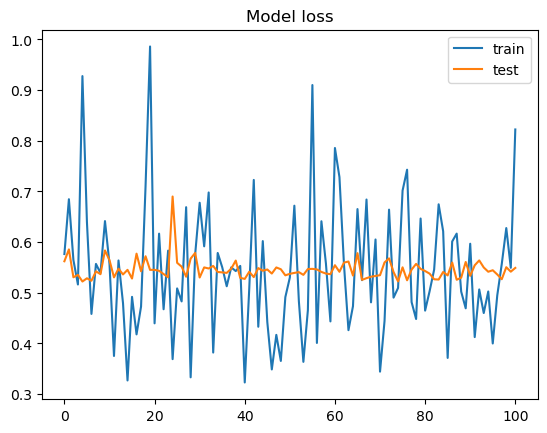

In [13]:
plt.figure()
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.title('Model loss')
plt.legend(loc='upper right')
plt.show()

In [11]:
# model 의 학습된 파라미터 확인
model.state_dict()

OrderedDict([('weight',
              tensor([[ 0.8508,  0.1227, -0.2854,  0.3525, -0.0112, -0.0501, -0.8978, -0.8828]])),
             ('bias', tensor([2.0693]))])